# Imports

In [2]:
import pandas as  pd
import numpy as np
import inflection
import math
import seaborn as sb
import random
import pickle
import warnings
import inflection
from datetime import datetime

from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sb.set()

# Remove a exibição de notação científica
pd.set_option('float_format', '{:.2f}'.format)

# Arredonda duas casas decimais
pd.set_option('display.precision', 2)

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\alexa\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## loading Data

In [7]:
# Import Dataset
data = pd.read_csv(r'C:\Users\alexa\Documents\repos\pa004_health_insurance_cross_sell\raw_data.csv')
data_raw = data.copy()

# Description of the Data

In [8]:
data.head(5)

,Unnamed: 0,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,0,Male,23,11.00,152.00,1,< 1 Year,Yes,0,23367.00,249,0
1,1,Female,41,15.00,14.00,1,1-2 Year,No,1,31409.00,221,0
2,2,Female,25,35.00,152.00,1,< 1 Year,No,1,46622.00,299,0
3,3,Female,26,8.00,160.00,1,< 1 Year,No,0,2630.00,136,0
4,4,Male,45,8.00,124.00,1,1-2 Year,Yes,0,42297.00,264,0


## Rename Columns

In [10]:
data.rename ( columns = {'Unnamed: 0' : 'id' }, inplace = True)

In [11]:
data.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

## Data Dimensions

In [12]:
print ('Number of Rows: {}' .format ( data.shape[0]))
print ('Number of Cols: {}' .format ( data.shape[1]))

Number of Rows: 381109
Number of Cols: 12


## Data Dimensions

In [13]:
data.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## Check NA

In [14]:
data.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## Descriptive Statistics

In [15]:
df1 = data

In [16]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

## Numerical Atributes

In [17]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.00,381108.00,381108.00,190554.00,190554.00,110016.69,0.00,-1.20
1,age,20.00,85.00,65.00,38.82,36.00,15.51,0.67,-0.57
2,region_code,0.00,52.00,52.00,26.39,28.00,13.23,-0.12,-0.87
3,policy_sales_channel,1.00,163.00,162.00,112.03,133.00,54.20,-0.90,-0.97
4,driving_license,0.00,1.00,1.00,1.00,1.00,0.05,-21.60,464.35
5,previously_insured,0.00,1.00,1.00,0.46,0.00,0.50,0.17,-1.97
6,annual_premium,2630.00,540165.00,537535.00,30564.39,31669.00,17213.13,1.77,34.00
7,vintage,10.00,299.00,289.00,154.35,154.00,83.67,0.00,-1.20
8,response,0.00,1.00,1.00,0.12,0.00,0.33,2.30,3.30


<AxesSubplot:xlabel='annual_premium'>

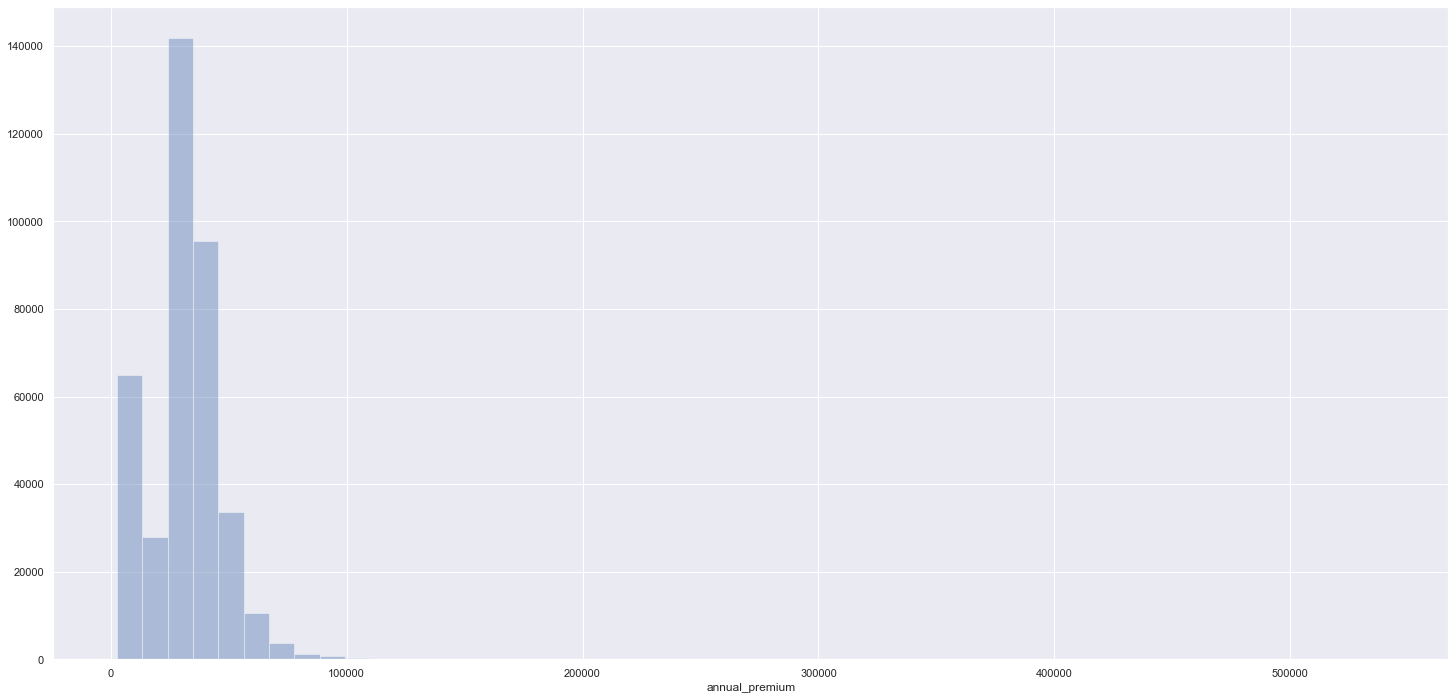

In [19]:
sb.distplot( df1['annual_premium'], kde=False )

## Categorical Atributes

## Identify and work with Outliers

In [21]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
maxim = pd.DataFrame(num_attributes.apply(np.max))
minim = pd.DataFrame(num_attributes.apply(np.min))
df_outlier = pd.concat([maxim, minim], axis=1).reset_index()
df_outlier.columns = ['ATTRIBUTES', 'MAX', 'MIN']
#print(df1)

In [25]:
print(df_outlier)

             ATTRIBUTES       MAX     MIN
0                    id 381108.00    0.00
1                   age     85.00   20.00
2           region_code     52.00    0.00
3  policy_sales_channel    163.00    1.00
4       driving_license      1.00    0.00
5    previously_insured      1.00    0.00
6        annual_premium 540165.00 2630.00
7               vintage    299.00   10.00
8              response      1.00    0.00


In [26]:
df_outlier

,ATTRIBUTES,MAX,MIN
0,id,381108.00,0.00
1,age,85.00,20.00
2,region_code,52.00,0.00
3,policy_sales_channel,163.00,1.00
4,driving_license,1.00,0.00
5,previously_insured,1.00,0.00
6,annual_premium,540165.00,2630.00
7,vintage,299.00,10.00
8,response,1.00,0.00
